In [35]:
!pip install boto3 zarr matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.5 MB/s eta 0:00:00


In [36]:
import boto3
import os
from botocore import UNSIGNED
from botocore.client import Config

In [4]:
bucket = 'e11bio-prism'

In [6]:
client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [19]:
def list_dirs(client, bucket, prefix=""):
    paginator = client.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix, Delimiter="/"):
        for cp in page.get("CommonPrefixes", []):
            yield cp["Prefix"]  # always endswith '/'

def hidden_in(path_rel: str) -> bool:
    parts = [p for p in path_rel.split("/") if p]
    return any(p.startswith(".") for p in parts)

def parse_skip_dirs(pairs):
    out = {}
    for p in pairs or []:
        if ":" not in p:
            raise ValueError(f"--skip-dir must be NAME:LEVELS, got {p!r}")
        name, levels = p.split(":", 1)
        name = name.strip().strip("/")
        out[name] = int(levels)
    return out

def should_block_recursion(ancestors, child_name, skip_spec):
    if not skip_spec:
        return False

    for i in range(len(ancestors) - 1, -1, -1):
        anc = ancestors[i]
        if anc in skip_spec:
            L = skip_spec[anc]
            rel_next = (len(ancestors) - i)
            if rel_next >= L:
                return True
            else:
                return False
    return False

def walk_dirs(
    client, bucket, prefix="", ancestors=None, depth=0, max_depth=0,
    skip_zarr=True, zarr_first_level=False, skip_spec=None
):
    if ancestors is None:
        ancestors = []

    children = sorted(list(list_dirs(client, bucket, prefix)))
    for child in children:
        name = child[len(prefix):].rstrip("/")  # relative name at this level
        if hidden_in(name):
            continue

        is_zarr = name.endswith(".zarr")
        print("  " * depth + f"- {name}/")

        if max_depth and depth >= max_depth:
            continue

        if is_zarr:
            if skip_zarr:
                continue
            if zarr_first_level:
                # list only immediate sub-dirs under the zarr, then stop
                subdirs = sorted(list(list_dirs(client, bucket, child)))
                for sd in subdirs:
                    rel = sd[len(child):].rstrip("/")
                    if hidden_in(rel):
                        continue
                    print("  " * (depth + 1) + f"- {rel}/")
                continue

        # useful to not descend into large dirs eg precomputed
        if should_block_recursion(ancestors, name, skip_spec or {}):
            continue

        # recurse
        walk_dirs(
            client, bucket, child,
            ancestors=ancestors + [name],
            depth=depth + 1,
            max_depth=max_depth,
            skip_zarr=skip_zarr,
            zarr_first_level=zarr_first_level,
            skip_spec=skip_spec
        )

In [20]:
walk_dirs(client, bucket, skip_spec={'precomputed':1})

- ls/
  - images/
    - full_dataset.zarr/
    - precomputed/
      - combined_affs/
      - dense_seg/
      - enhanced/
      - local_seg_full/
      - local_seg_spines/
      - markers_all/
      - post_mask_dense_seg/
      - post_mask_local_seg_spines/
      - pre_mask_dense_seg/
      - pre_mask_local_seg_spines/
      - proofed_cells/
      - raw/
      - segments_relabeled/
  - models/
    - checkpoints/
      - affs/
      - binary_channel_agnostic/
      - enhanced/
      - uniform/
    - training_data/
      - instance/
        - crop_0.zarr/
        - crop_1.zarr/
        - crop_10.zarr/
        - crop_11.zarr/
        - crop_12.zarr/
        - crop_13.zarr/
        - crop_2.zarr/
        - crop_3.zarr/
        - crop_4.zarr/
        - crop_5.zarr/
        - crop_6.zarr/
        - crop_7.zarr/
        - crop_8.zarr/
        - crop_9.zarr/
      - semantic/
        - crop_0.zarr/
        - crop_1.zarr/
        - crop_10.zarr/
        - crop_11.zarr/
        - crop_12.zarr/
 

In [21]:
walk_dirs(client, bucket, prefix='ls/models/training_data/instance/crop_0.zarr')

- /
  - labels/
  - raw/


In [23]:
# function to download all files nested in a bucket path
def downloadDirectory(
    bucket_name,
    path):

    resource = boto3.resource(
        's3',
        config=Config(signature_version=UNSIGNED)
    )

    bucket = resource.Bucket(bucket_name)

    for obj in bucket.objects.filter(Prefix=path):
        if not os.path.exists(os.path.dirname(obj.key)):
            os.makedirs(os.path.dirname(obj.key))

        key = obj.key

        print(f'Downloading {key}')
        bucket.download_file(key, key)

In [26]:
# download example fib25 training data
downloadDirectory(
    bucket,
    'ls/models/training_data/instance/crop_0.zarr'
)

In [37]:
ls

ls/  sample_data/


In [38]:
import zarr

f = zarr.open('ls/models/training_data/instance/crop_0.zarr')

In [39]:
# load data into numpy arrays
raw = f['raw'][:]
labels = f['labels'][:]

In [41]:
raw.shape, labels.shape, raw.dtype, labels.dtype

((18, 300, 650, 650), (200, 500, 500), dtype('uint8'), dtype('<u8'))

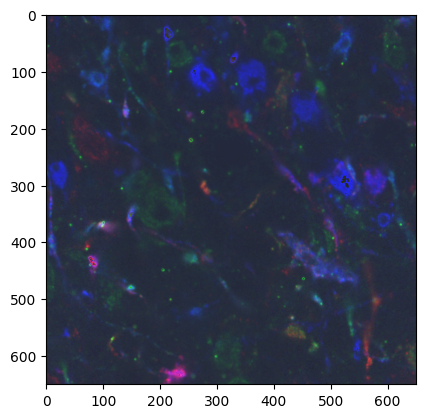

In [50]:
import matplotlib.pyplot as plt

# show data
plt.imshow(raw[0:3,100].T*5)

In [53]:
import numpy as np

# utility function for viewing unique labels
def create_lut(labels):

    max_label = np.max(labels)

    lut = np.random.randint(
            low=0,
            high=255,
            size=(int(max_label + 1), 3),
            dtype=np.uint64)

    lut = np.append(
            lut,
            np.zeros(
                (int(max_label + 1), 1),
                dtype=np.uint8) + 255,
            axis=1)

    lut[0] = 0
    colored_labels = lut[labels]

    return colored_labels

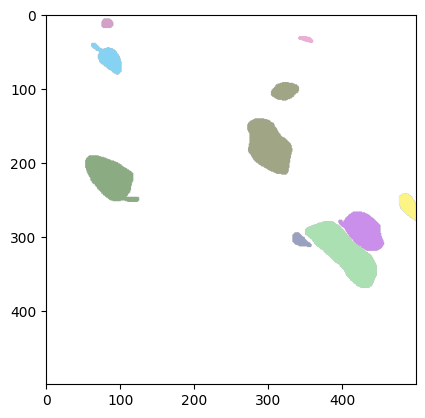

In [64]:
plt.imshow(create_lut(labels[100]), alpha=0.5)